# Earnings Calendar Spread Strategy

### __Pulling in data from S Drive__

In [1]:
import os
from pathlib import Path
from dotenv import load_dotenv
load_dotenv()
tick_path = os.getenv("TICK_PATH", "").split(os.pathsep)[0]

p = Path(tick_path)
if p.is_dir():  # make sure it exists
    available_ticks =[f.name.replace('.parquet', '') for f in p.iterdir() if f.is_file()]

### __Building Prediction Pipeline__

#### __Defining the universe__
The entire execution pipeline is handled via the DataManager class, so we just add methods to the pipline which get executed once the pipeline is populated. Due to the volume of data to be processed, options chains are pulled in in parallel, processed and then deleted from memory. Necessary data are retained in the model and used for later inference. 

In [2]:
import options_wizard as ow

stocks = [
    "AAPL", "MSFT", "NVDA", "GOOG", "GOOGL",
    "AMZN", "META", "AVGO", "TSLA", "PEP",
    "COST", "NFLX", "ADBE", "CSCO", "AMD",
    "INTC", "LIN", "TXN", "QCOM", "AMAT"
]
for stock in stocks.copy():
    if stock not in available_ticks:
        print(f"Removing {stock} from universe - data not available")
        stocks.remove(stock)

universe = ow.Universe(stocks)
data_manager = ow.DataManager(universe, load_lazy=True)

#### __Transforming the Data__
Data transformations are those which will define the dataset for a given stock, that can be then used to infer features, returns and execute strategies. These methods can filter out contracts, changing the size of the options chain dataframe. These, along with the rest of the dataset are deleted once the tick's pipeline has been executed.

In [3]:
ow.Transformer(data_manager)('scale_by_splits')
ow.Transformer(data_manager)('to_datetime', columns=['trade_date', 'expiry_date'])
ow.Transformer(data_manager)('drop_stale_options', volume_threshold=100)
ow.Transformer(data_manager)('pull_earnings_dates')
ow.Transformer(data_manager)('set_index', index_cols=['strike', 'trade_date', 'expiry_date', 'call_put'], dedupe=True)
ow.Transformer(data_manager)('filter_ttms', min_ttm=3)
ow.Transformer(data_manager)('compute_rv', period=30)
ow.Transformer(data_manager)('train_test_split', test_size=0.35, drop_out_of_sample=True)
ow.Transformer(data_manager)('implied_volatility')
ow.Transformer(data_manager)('mid_price')

#### __Adding Features to the Data__
Data features are those which will will be used for prediction. These are stored separatley from transformations, to keep the model inference process light-weight. These will be retained once the individual tick's pipeline has been executed

In [4]:
ow.Features(data_manager)('iv_rv_ratio')
ow.Features(data_manager)('term_structure_slope', near_expiry_days=10, far_expiry_days=30)
ow.Features(data_manager)('mac_vol', lookback_short=5, lookback_long=15)
ow.Features(data_manager)('days_to_earnings')
ow.Features(data_manager)('days_since_earnings')

#### __Defining the Trade Strategy__
This defines the trade strategy for the model. It is important that the returns of the strategy are fit to the same row as the features of the strategy. Ie if you have an entry signal, the returns of the subsequent trade should be in the same column as the entry signal.

In [5]:
ow.Strategy(data_manager)(
    'earnings_calendar_spread',
    entry_offset=1,
    exit_offset=0,
    ttm_short=10,
    ttm_long=30,
    call_delta=0.35,
    put_delta=-0.35,
    position=1
)

#### __Model prediction and Pipeline Execution__
Prepare data will combine entires accross all contracts on a given day (for multi-contract strategies, such as spreads, butterflies, eagles etc). Then we can define our prediction model, defining the features of our predictor variables and our target prediction variable. If all_stocks == True, the model will fit one model accross all the stocks, by removing this from the pipeline, executing the individual stock pipelines and then execute the model fit step at the end. The model pipeline execution is paralelised accross available cores, this is defaulted to at 8 due to memory issues.

In [6]:
ow.Features(data_manager)('prepare_data', feature_names=['iv_rv_ratio', 'avg_slope', 'mac_volume'])
ow.model.MLP(data_manager)('fit_predict', y_col='long_pnl', X_cols=['iv_rv_ratio', 'theta_log_ratio', 'avg_slope', 'mac_volume'], all_stocks=True, diff_ticks='tick', save_params=True)
ow.model.LinReg(data_manager)('fit_predict', y_col='long_pnl', X_cols=['iv_rv_ratio', 'theta_log_ratio', 'avg_slope', 'mac_volume'], all_stocks=True, diff_ticks='tick', save_params=True)
ow.model.LogReg(data_manager)('fit_predict', y_col='long_pnl', X_cols=['iv_rv_ratio', 'theta_log_ratio', 'avg_slope', 'mac_volume'], all_stocks=True, diff_ticks='tick', save_params=True)
data_manager.execute_pipeline(retain_data=False, save_data=False)

Deferring method fit_predict for all stocksRunning post-processing method fit_predict for ticks ['AAPL', 'MSFT', 'NVDA', 'GOOG', 'GOOGL', 'AMZN', 'META', 'AVGO', 'TSLA', 'PEP', 'COST', 'NFLX', 'ADBE', 'CSCO', 'AMD', 'INTC', 'LIN', 'TXN', 'QCOM', 'AMAT']
Running post-processing method fit_predict for ticks ['AAPL', 'MSFT', 'NVDA', 'GOOG', 'GOOGL', 'AMZN', 'META', 'AVGO', 'TSLA', 'PEP', 'COST', 'NFLX', 'ADBE', 'CSCO', 'AMD', 'INTC', 'LIN', 'TXN', 'QCOM', 'AMAT']
Running post-processing method fit_predict for ticks ['AAPL', 'MSFT', 'NVDA', 'GOOG', 'GOOGL', 'AMZN', 'META', 'AVGO', 'TSLA', 'PEP', 'COST', 'NFLX', 'ADBE', 'CSCO', 'AMD', 'INTC', 'LIN', 'TXN', 'QCOM', 'AMAT']


#### __Result Visualisation__ 

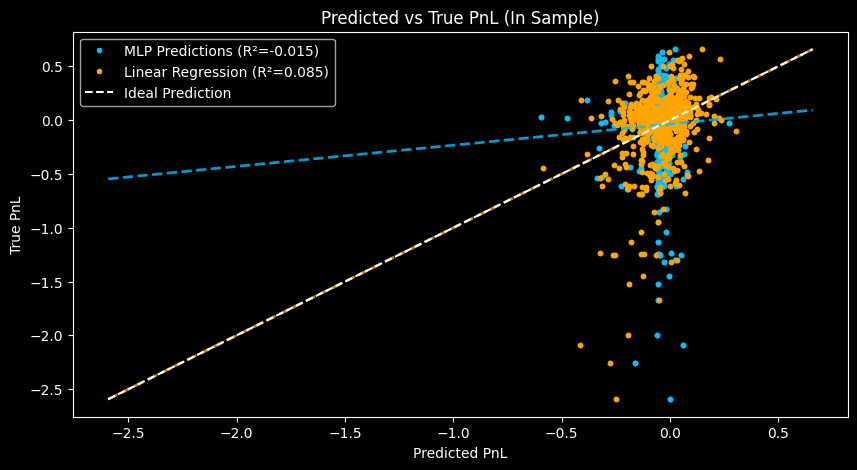

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

plt.style.use('dark_background')
plt.figure(figsize=(10,5))

# --- Helper functions ---
def to_numeric(array):
    """Convert to float array, coercing bad values to NaN."""
    return np.array(array, dtype=float)

def clean_data(pred, true):
    """Remove NaNs from prediction/true pairs."""
    mask = ~np.isnan(pred) & ~np.isnan(true)
    return pred[mask], true[mask]

# --- Extract and clean data ---
true_pnl = to_numeric(data_manager.combined_outputs['fit_predict']['long_pnl'])
mlp_pred = to_numeric(data_manager.combined_outputs['fit_predict']['mlp_pred'])
lin_pred = to_numeric(data_manager.combined_outputs['fit_predict']['linreg_pred'])

mlp_pred, true_mlp = clean_data(mlp_pred, true_pnl)
lin_pred, true_lin = clean_data(lin_pred, true_pnl)

# --- Compute metrics safely ---
def safe_r2(y_true, y_pred):
    return r2_score(y_true, y_pred) if len(y_true) > 1 else np.nan

def safe_polyfit(x, y):
    return np.polyfit(x, y, 1) if len(x) > 1 else (np.nan, np.nan)

r2_mlp = safe_r2(true_mlp, mlp_pred)
r2_lin = safe_r2(true_lin, lin_pred)
slope_mlp, intercept_mlp = safe_polyfit(mlp_pred, true_mlp)
slope_lin, intercept_lin = safe_polyfit(lin_pred, true_lin)

# --- Plot points ---
if len(mlp_pred) > 0:
    plt.plot(mlp_pred, true_mlp, '.', color='deepskyblue', label=f'MLP Predictions (R²={r2_mlp:.3f})')
if len(lin_pred) > 0:
    plt.plot(lin_pred, true_lin, '.', color='orange', label=f'Linear Regression (R²={r2_lin:.3f})')


# --- Determine plotting range safely ---
all_values = np.concatenate([arr for arr in [true_pnl, mlp_pred, lin_pred] if len(arr) > 0])
if len(all_values) > 0:
    x_vals = np.linspace(np.nanmin(all_values), np.nanmax(all_values), 100)

    # Plot LOBFs
    if not np.isnan(slope_mlp):
        plt.plot(x_vals, slope_mlp * x_vals + intercept_mlp, color='deepskyblue', lw=2, linestyle='--', alpha=0.8)
    if not np.isnan(slope_lin):
        plt.plot(x_vals, slope_lin * x_vals + intercept_lin, color='orange', lw=2, linestyle='--', alpha=0.8)

# --- Ideal line ---
plt.plot(x_vals, x_vals, '--', color='white', label='Ideal Prediction')

# --- Labels & legend ---
plt.xlabel('Predicted PnL')
plt.ylabel('True PnL')
plt.legend()
plt.title('Predicted vs True PnL (In Sample)')
plt.grid(False)
plt.show()


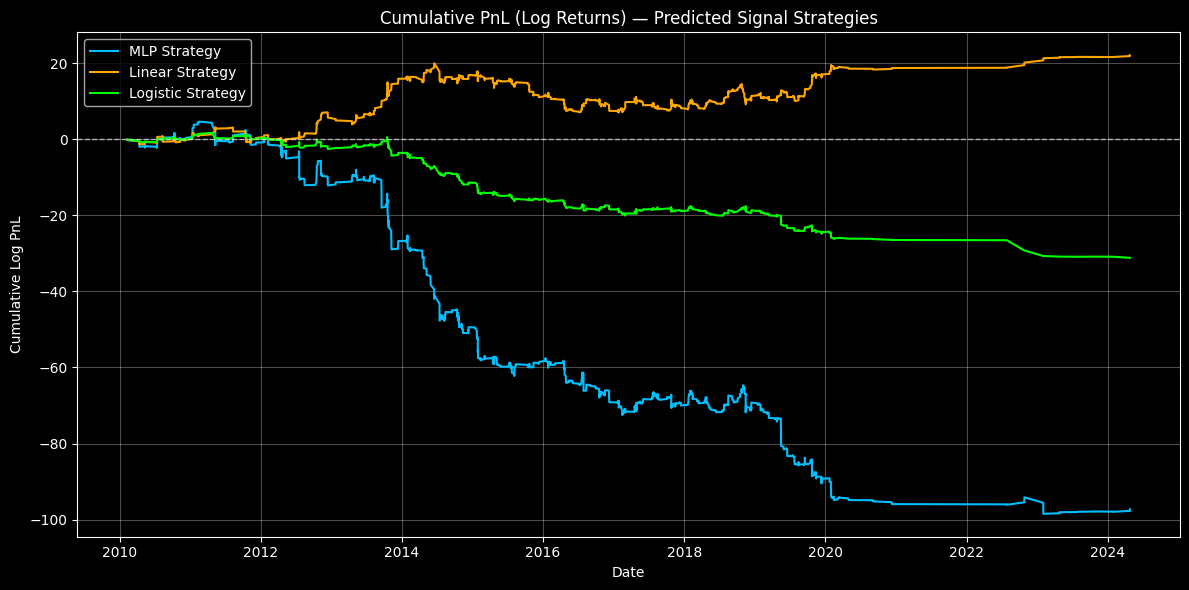

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('dark_background')
plt.figure(figsize=(12, 6))

# --- Helper function ---
def compute_strategy_pnl(pred, long_true, short_true, threshold=None):
    """
    Compute PnL given predicted signals and separate long/short true returns.
    If pred > 0 → take long_true, if pred < 0 → take short_true.
    """
    pred = np.array(pred, dtype=float)
    long_true = np.array(long_true, dtype=float)
    short_true = np.array(short_true, dtype=float)
    
    n = min(len(pred), len(long_true), len(short_true))
    pred, long_true, short_true = pred[:n], long_true[:n], short_true[:n]
    
    if threshold is None:
        threshold = 0.0
        signal = np.sign(pred)
    else:
        signal = pred
    daily_pnl = np.where(signal > threshold, long_true, np.where(signal < threshold, short_true, 0.0))
    cumulative_pnl = np.cumsum(daily_pnl)
    return cumulative_pnl, daily_pnl

# --- Base index ---
dates = data_manager.combined_outputs['fit_predict'].index

# --- Convert to numeric safely ---
mlp_series = pd.to_numeric(data_manager.combined_outputs['fit_predict']['mlp_pred'], errors='coerce')
lin_series = pd.to_numeric(data_manager.combined_outputs['fit_predict']['linreg_pred'], errors='coerce')
lgr_series = pd.to_numeric(data_manager.combined_outputs['fit_predict']['logreg_pred'], errors='coerce')
long_series = pd.to_numeric(data_manager.combined_outputs['fit_predict']['long_pnl'], errors='coerce')
short_series = pd.to_numeric(data_manager.combined_outputs['fit_predict']['short_pnl'], errors='coerce')

# --- Clean and align each dataset ---
mlp_df = pd.DataFrame({
    'pred': mlp_series,
    'long_true': long_series,
    'short_true': short_series
}).dropna().sort_index()

lin_df = pd.DataFrame({
    'pred': lin_series,
    'long_true': long_series,
    'short_true': short_series
}).dropna().sort_index()

lgr_df = pd.DataFrame({
    'pred': lgr_series,
    'long_true': long_series,
    'short_true': short_series
}).dropna().sort_index()

# --- Compute strategy PnLs ---
mlp_cum, mlp_daily = compute_strategy_pnl(mlp_df['pred'], mlp_df['long_true'], mlp_df['short_true'])
lin_cum, lin_daily = compute_strategy_pnl(lin_df['pred'], lin_df['long_true'], lin_df['short_true'])
lgr_cum, lgr_daily = compute_strategy_pnl(lgr_df['pred'], lgr_df['long_true'], lgr_df['short_true'], threshold=1)

# --- Plot cumulative PnL curves ---
plt.plot(mlp_df.index, mlp_cum, label='MLP Strategy', color='deepskyblue')
plt.plot(lin_df.index, lin_cum, label='Linear Strategy', color='orange')
plt.plot(lgr_df.index, lgr_cum, label='Logistic Strategy', color='lime')
plt.axhline(0, color='white', lw=1, linestyle='--', alpha=0.6)

# --- Labels and style ---
plt.title('Cumulative PnL (Log Returns) — Predicted Signal Strategies')
plt.xlabel('Date')
plt.ylabel('Cumulative Log PnL')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [9]:
lgr_df['pred'].describe()

count    656.000000
mean       0.596636
std        0.143159
min        0.042019
25%        0.522088
50%        0.602196
75%        0.685367
max        0.971723
Name: pred, dtype: float64

In [10]:
lgr_df[['short_true', 'long_true']]

,short_true,long_true
trade_date_idx,,
2010-02-10 00:00:00-05:00,-0.077269,0.071724
2010-04-12 00:00:00-04:00,-0.270393,0.212625
2010-04-13 00:00:00-04:00,-0.308650,0.235516
2010-05-12 00:00:00-04:00,-0.106413,0.096170
2010-05-12 00:00:00-04:00,0.183004,-0.224169
...,...,...
2023-07-26 00:00:00-04:00,-0.037114,0.035786
2023-10-25 00:00:00-04:00,0.028002,-0.028809
2024-01-31 00:00:00-05:00,-0.022509,0.022013
